# Fully-Connected Neural Nets

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from neuralnet.classifiers.fc_net import *
from neuralnet.data_utils import get_CIFAR10_data
from neuralnet.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from neuralnet.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Multilayer network

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [14]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.86e-09
W2 relative error: 3.52e-08
W3 relative error: 1.32e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 357422.248338
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.114000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.141000
(Epoch 2 / 20) train acc: 0.540000; val_acc: 0.142000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.156000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.170000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.154000
(Iteration 11 / 40) loss: 2990.880358
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.152000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.146000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.150000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.142000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.142000
(Iteration 21 / 40) loss: 1934.093573
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.144000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.144000
(Iteration 31 /

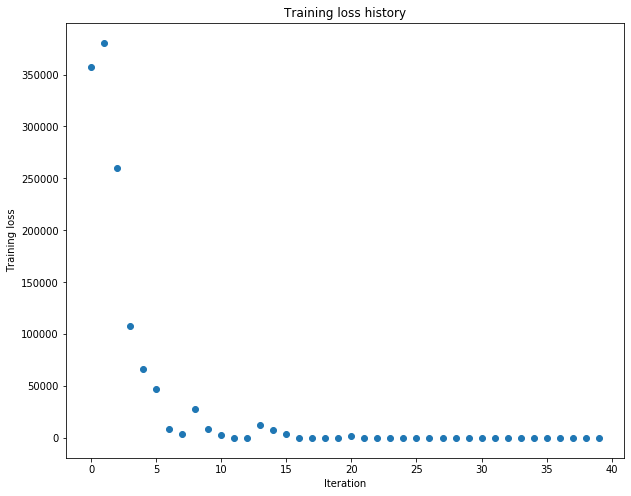

In [15]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1  # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

running with  sgd
(Iteration 1 / 200) loss: 2.678863
(Epoch 0 / 5) train acc: 0.110000; val_acc: 0.111000
(Iteration 11 / 200) loss: 2.274933
(Iteration 21 / 200) loss: 2.175633
(Iteration 31 / 200) loss: 2.097040
(Epoch 1 / 5) train acc: 0.256000; val_acc: 0.220000
(Iteration 41 / 200) loss: 2.107710
(Iteration 51 / 200) loss: 2.160821
(Iteration 61 / 200) loss: 1.951036
(Iteration 71 / 200) loss: 1.886787
(Epoch 2 / 5) train acc: 0.323000; val_acc: 0.248000
(Iteration 81 / 200) loss: 2.126963
(Iteration 91 / 200) loss: 1.867634
(Iteration 101 / 200) loss: 1.948371
(Iteration 111 / 200) loss: 1.838423
(Epoch 3 / 5) train acc: 0.289000; val_acc: 0.257000
(Iteration 121 / 200) loss: 1.941790
(Iteration 131 / 200) loss: 1.820515
(Iteration 141 / 200) loss: 1.865708
(Iteration 151 / 200) loss: 1.838536
(Epoch 4 / 5) train acc: 0.351000; val_acc: 0.279000
(Iteration 161 / 200) loss: 1.900851
(Iteration 171 / 200) loss: 1.911379
(Iteration 181 / 200) loss: 1.806556
(Iteration 191 / 200) los

/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

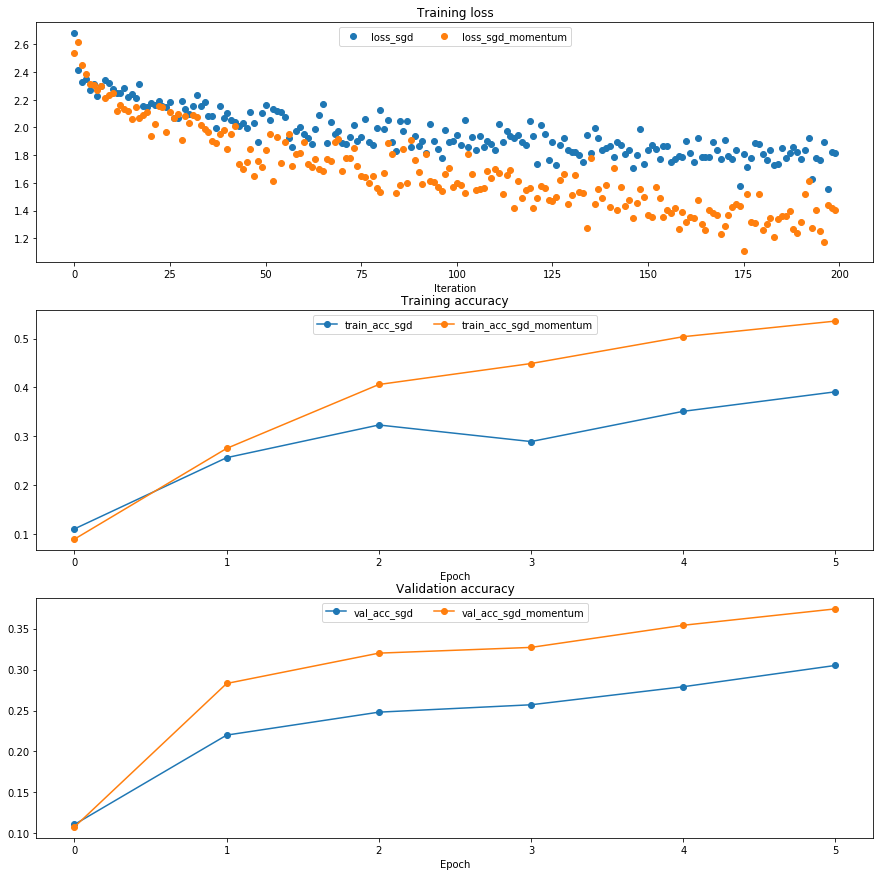

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()